In [1]:
!git clone https://github.com/SyedMa3/eva-template.git
%cd eva-template/

Cloning into 'eva-template'...
remote: Enumerating objects: 107, done.
remote: Counting objects: 100% (107/107), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 107 (delta 48), reused 89 (delta 30), pack-reused 0
Receiving objects: 100% (107/107), 19.15 KiB | 9.57 MiB/s, done.
Resolving deltas: 100% (48/48), done.
/content/eva-template


In [2]:
!pip install torch_lr_finder

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%cd eva-template

[Errno 2] No such file or directory: 'eva-template'
/content/eva-template


In [ ]:
!git fetch
!git pull

Already up to date.


In [3]:
import matplotlib.pyplot as plt
import numpy as np

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import datasets, transforms
from tqdm import tqdm

In [4]:
from models.custom_resnet import MakeResNet
from main import fit_model

In [5]:
# loading the dataset
exp = datasets.CIFAR10('./data', train=True, download=True)
exp_data = exp.data

# Calculate the mean and std for normalization
print('[Train]')
print(' - Numpy Shape:', exp_data.shape)
print(' - min:', np.min(exp_data, axis=(0,1,2)) / 255.)
print(' - max:', np.max(exp_data, axis=(0,1,2)) / 255.)
print(' - mean:', np.mean(exp_data, axis=(0,1,2)) / 255.)
print(' - std:', np.std(exp_data, axis=(0,1,2)) / 255.)
print(' - var:', np.var(exp_data, axis=(0,1,2)) / 255.)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
[Train]
 - Numpy Shape: (50000, 32, 32, 3)
 - min: [0. 0. 0.]
 - max: [1. 1. 1.]
 - mean: [0.49139968 0.48215841 0.44653091]
 - std: [0.24703223 0.24348513 0.26158784]
 - var: [15.56135559 15.11767693 17.44919073]


In [6]:
# custom dataset class for albumentations library
class AlbumentationImageDataset(Dataset):
  def __init__(self, image_list, train= True):
      self.image_list = image_list
      self.aug = A.Compose(
                [
                    # A.OneOf([
                      A.Sequential([
                          A.PadIfNeeded(min_height=40, min_width=40, always_apply=True),  # padding of 4 on each side of 32x32 image
                          A.RandomCrop(height=32, width=32, always_apply=True),
                          A.CoarseDropout(max_height=8, max_width=8, min_height=8, min_width=8, min_holes=1, max_holes=1, fill_value=(0.49139968, 0.48215841, 0.44653091), always_apply=True),
                      ], p=1),
                        # A.Sequential([
                        # ], p=1)
                    # ], p=1),  # Always apply at least one of the above transformations.
                    A.HorizontalFlip(),
                    A.Normalize(mean=(0.49139968, 0.48215841, 0.44653091), std=(0.24703223, 0.24348513, 0.26158784), always_apply=True),
                ]
            )

      self.norm = A.Compose({A.Normalize((0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784), always_apply=True),
      })
      self.train = train
        
  def __len__(self):
      return (len(self.image_list))

  def __getitem__(self, i):
      
      image, label = self.image_list[i]
      
      if self.train:
        #apply augmentation only for training
        image = self.aug(image=np.array(image))['image']
      else:
        image = self.norm(image=np.array(image))['image']
      image = np.transpose(image, (2, 0, 1)).astype(np.float32)
      return torch.tensor(image, dtype=torch.float), label

In [7]:
SEED = 69

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available:", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)
    BATCH_SIZE=512
else:
    BATCH_SIZE=512

CUDA Available: True


In [8]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True )
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True)


train_loader = torch.utils.data.DataLoader(AlbumentationImageDataset(trainset, train=True), batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(AlbumentationImageDataset(testset, train=False), batch_size=BATCH_SIZE,
                                          shuffle=False, num_workers=1)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
net = MakeResNet().to(device)
summary(net, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3          [-1, 128, 32, 32]          73,728
         MaxPool2d-4          [-1, 128, 16, 16]               0
       BatchNorm2d-5          [-1, 128, 16, 16]             256
              ReLU-6          [-1, 128, 16, 16]               0
            Conv2d-7          [-1, 128, 16, 16]         147,456
       BatchNorm2d-8          [-1, 128, 16, 16]             256
            Conv2d-9          [-1, 128, 16, 16]         147,456
      BatchNorm2d-10          [-1, 128, 16, 16]             256
       BasicBlock-11          [-1, 128, 16, 16]               0
           Conv2d-12          [-1, 256, 16, 16]         294,912
        MaxPool2d-13            [-1, 256, 8, 8]               0
      BatchNorm2d-14            [-

In [10]:
from torch_lr_finder import LRFinder


def find_lr(net, optimizer, criterion, train_loader, device):
    """Find learning rate for using One Cyclic LRFinder
    Args:
        net (instace): torch instace of defined model
        optimizer (instance): optimizer to be used
        criterion (instance): criterion to be used for calculating loss
        train_loader (instance): torch dataloader instace for trainig set
    """
    lr_finder = LRFinder(net, optimizer, criterion, device)
    lr_finder.range_test(train_loader, end_lr=10, num_iter=200, step_mode="exp")
    lr_finder.plot()
    lr_finder.reset()
    min_loss = min(lr_finder.history['loss'])
    ler_rate = lr_finder.history['lr'][np.argmin(lr_finder.history['loss'], axis=0)]
    print(f'Max LR is {ler_rate}')

    return ler_rate

  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 6.22E-01


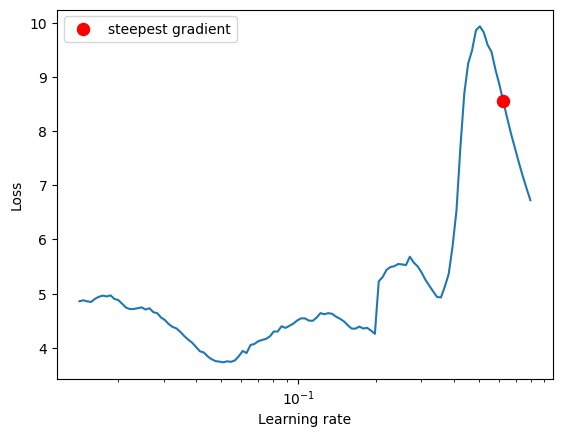

Max LR is 0.01


In [11]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()
ler_rate = find_lr(net, optimizer, criterion, train_loader, device)

In [12]:
# net = MakeResNet().to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                max_lr=ler_rate,
                                                steps_per_epoch=len(train_loader), 
                                                epochs=24,
                                                pct_start=0.15,
                                                div_factor=10,
                                                three_phase=False, 
                                                final_div_factor=10,
                                                anneal_strategy='linear'
                                                )

net, history = fit_model(
    net=net,
    device=device,
    optimizer=optimizer,
    criterion=criterion,
    NUM_EPOCHS=24,
    train_loader=train_loader,
    test_loader=test_loader,
    scheduler=scheduler
)

EPOCH: 1 (LR: 0.001)


Batch_id=97 Loss=1.78257 Accuracy=36.84:   0%|          | 0/98 [00:27<?, ?it/s]



Test set: Average loss: 1.2610, Accuracy: 5578/10000 (55.78%)

EPOCH: 2 (LR: 0.0035071063104036384)


Batch_id=97 Loss=1.20895 Accuracy=56.48:   0%|          | 0/98 [00:26<?, ?it/s]



Test set: Average loss: 1.0608, Accuracy: 6357/10000 (63.57%)

EPOCH: 3 (LR: 0.006014212620807277)


Batch_id=97 Loss=1.01302 Accuracy=64.22:   0%|          | 0/98 [00:26<?, ?it/s]



Test set: Average loss: 0.9145, Accuracy: 6868/10000 (68.68%)

EPOCH: 4 (LR: 0.008521318931210916)


Batch_id=97 Loss=0.85128 Accuracy=70.08:   0%|          | 0/98 [00:26<?, ?it/s]



Test set: Average loss: 0.8127, Accuracy: 7225/10000 (72.25%)

EPOCH: 5 (LR: 0.00980093037214886)


Batch_id=97 Loss=0.74246 Accuracy=74.13:   0%|          | 0/98 [00:26<?, ?it/s]



Test set: Average loss: 0.7430, Accuracy: 7504/10000 (75.04%)

EPOCH: 6 (LR: 0.0093156362545018)


Batch_id=97 Loss=0.66310 Accuracy=76.85:   0%|          | 0/98 [00:27<?, ?it/s]



Test set: Average loss: 0.5859, Accuracy: 8039/10000 (80.39%)

EPOCH: 7 (LR: 0.008830342136854743)


Batch_id=97 Loss=0.58562 Accuracy=79.56:   0%|          | 0/98 [00:26<?, ?it/s]



Test set: Average loss: 0.5873, Accuracy: 8008/10000 (80.08%)

EPOCH: 8 (LR: 0.008345048019207683)


Batch_id=97 Loss=0.54075 Accuracy=81.01:   0%|          | 0/98 [00:26<?, ?it/s]



Test set: Average loss: 0.6139, Accuracy: 7940/10000 (79.40%)

EPOCH: 9 (LR: 0.007859753901560625)


Batch_id=97 Loss=0.49845 Accuracy=82.74:   0%|          | 0/98 [00:26<?, ?it/s]



Test set: Average loss: 0.5836, Accuracy: 8105/10000 (81.05%)

EPOCH: 10 (LR: 0.007374459783913565)


Batch_id=97 Loss=0.45343 Accuracy=84.21:   0%|          | 0/98 [00:26<?, ?it/s]



Test set: Average loss: 0.5002, Accuracy: 8328/10000 (83.28%)

EPOCH: 11 (LR: 0.006889165666266506)


Batch_id=97 Loss=0.42565 Accuracy=85.09:   0%|          | 0/98 [00:27<?, ?it/s]



Test set: Average loss: 0.4820, Accuracy: 8373/10000 (83.73%)

EPOCH: 12 (LR: 0.006403871548619447)


Batch_id=97 Loss=0.40174 Accuracy=85.84:   0%|          | 0/98 [00:26<?, ?it/s]



Test set: Average loss: 0.5040, Accuracy: 8347/10000 (83.47%)

EPOCH: 13 (LR: 0.005918577430972388)


Batch_id=97 Loss=0.36329 Accuracy=87.26:   0%|          | 0/98 [00:26<?, ?it/s]



Test set: Average loss: 0.4077, Accuracy: 8610/10000 (86.10%)

EPOCH: 14 (LR: 0.00543328331332533)


Batch_id=97 Loss=0.35138 Accuracy=87.78:   0%|          | 0/98 [00:26<?, ?it/s]



Test set: Average loss: 0.4392, Accuracy: 8526/10000 (85.26%)

EPOCH: 15 (LR: 0.004947989195678271)


Batch_id=97 Loss=0.32261 Accuracy=88.77:   0%|          | 0/98 [00:26<?, ?it/s]



Test set: Average loss: 0.3766, Accuracy: 8734/10000 (87.34%)

EPOCH: 16 (LR: 0.004462695078031212)


Batch_id=97 Loss=0.30116 Accuracy=89.49:   0%|          | 0/98 [00:26<?, ?it/s]



Test set: Average loss: 0.3663, Accuracy: 8792/10000 (87.92%)

EPOCH: 17 (LR: 0.003977400960384154)


Batch_id=97 Loss=0.27922 Accuracy=90.29:   0%|          | 0/98 [00:26<?, ?it/s]



Test set: Average loss: 0.3695, Accuracy: 8786/10000 (87.86%)

EPOCH: 18 (LR: 0.0034921068427370945)


Batch_id=97 Loss=0.26584 Accuracy=90.65:   0%|          | 0/98 [00:26<?, ?it/s]



Test set: Average loss: 0.3720, Accuracy: 8770/10000 (87.70%)

EPOCH: 19 (LR: 0.003006812725090036)


Batch_id=97 Loss=0.25497 Accuracy=91.06:   0%|          | 0/98 [00:26<?, ?it/s]



Test set: Average loss: 0.3573, Accuracy: 8821/10000 (88.21%)

EPOCH: 20 (LR: 0.0025215186074429765)


Batch_id=97 Loss=0.22987 Accuracy=91.99:   0%|          | 0/98 [00:26<?, ?it/s]



Test set: Average loss: 0.3570, Accuracy: 8841/10000 (88.41%)

EPOCH: 21 (LR: 0.0020362244897959188)


Batch_id=97 Loss=0.21893 Accuracy=92.34:   0%|          | 0/98 [00:25<?, ?it/s]



Test set: Average loss: 0.3309, Accuracy: 8927/10000 (89.27%)

EPOCH: 22 (LR: 0.0015509303721488593)


Batch_id=97 Loss=0.19939 Accuracy=93.20:   0%|          | 0/98 [00:26<?, ?it/s]



Test set: Average loss: 0.3136, Accuracy: 8958/10000 (89.58%)

EPOCH: 23 (LR: 0.0010656362545017999)


Batch_id=97 Loss=0.18714 Accuracy=93.60:   0%|          | 0/98 [00:26<?, ?it/s]



Test set: Average loss: 0.3119, Accuracy: 8970/10000 (89.70%)

EPOCH: 24 (LR: 0.0005803421368547421)


Batch_id=97 Loss=0.17518 Accuracy=93.93:   0%|          | 0/98 [00:26<?, ?it/s]



Test set: Average loss: 0.3028, Accuracy: 9002/10000 (90.02%)

